# General idea 
In this notebook the simple MLP was made from scratch using basic python libraries.
MLP is then used to make the simple binary classifier.  

## Libraries for MLP

Here are list of all libraries used to make a multi layer preceptron - the most simple neural network. 

In [1]:
import math 
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

# Class "Value".
Key features of this class:
- 1 Instance contains value

- 2 Instance contains information about previous values and actions which were used to calculate the value of current instance in "self._prev"

- 3 Instance contains something called gradient. We would get the value of a gradient from the _backward function of a child instance.

- 4 Instance has a function object which is called "_backward" for backpropagation.   

- 5 Class has methods to make actions like addition and multiplication. Each method redefines the "_backward" function object in his special way. 
E.g. If an instance was made by the addition of two Values instances, the backward function would not be the same as backward function of the multiplication of two Values.
- We define the _way_ by which backward function calculates the gradient using the rules of the calculus. 
- Backward function updates values of the gradient of parent instances -> from which the current instance was calculated. 

- 6 The is a class method backward which is using recursive function biuld_topo() to make a topology of parents for an Instance and apply _backward to each predecessor. 


In [2]:
class Value: 
    def __init__(self, data ,_children=(), _op="" ,label='') -> None:
        self.data=data
        self._prev=set(_children)
        self._op=_op
        self.grad = 0.0
        self.label=label
        self._backward = lambda : None
        pass
    def __repr__(self) -> str:
        return  f"value(data={self.data})"
    
    def __add__(self, other): 
        other = other if  isinstance(other, Value) else Value(other)
        out=Value(self.data+other.data ,(self, other) , '+')
        def _backward(): 
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward=_backward
        return out 
    
    def __radd__(self, other): 
        return self+other

    
    def __neg__(self): 
        return self*(-1)
    
    def __sub__(self,other): 
        return self+(-other)
    
    def __truediv__(self, other): 
        return self*(other**(-1))
    
    def __pow__ (self, other): 
        assert isinstance(other,(int,float)), "only integer nad floeat can be here "
        out = Value(self.data**other,(self,), f"**{other}") 
        def _backward():
            self.grad=other*(self.data**(other-1))*out.grad 
        out._backward=_backward   
        return out 

    def __rmul__(self, other): 
        return self*other
    
    def __mul__(self, other): 
        other = other if  isinstance(other, Value) else Value(other)
        out=Value(self.data*other.data, (self,other), "*")
        def _backward():
            self.grad += other.data*out.grad
            other.grad += self.data*out.grad
        out._backward=_backward
        return out 
    def tanh(self):
        n=self.data
        t = (math.exp(n*2)-1)/(math.exp(n*2)+1)
        out= Value(t , (self,), 'tanh') 
        def _backward():
            self.grad += out.grad*(1-t**2)
        out._backward=_backward
        return out
    
    def exp(self): 
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        def _backward():
            self.grad = out.data*out.grad
        out._backward=_backward
        return out

    def backward(self): 
        topo = [] 
        visited=set()
        def biuld_topo(v):
            if v not in visited:
                visited.add(v) 
                for child in v._prev: 
                    biuld_topo(child)
                topo.append(v)
        biuld_topo(self)
        self.grad=1
        for node in reversed(topo): 
            node._backward()

## Test 
Lets test how our class works.

In [3]:
a=Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label = 'c') 
e=a*b
e.label="e"
e, e.exp(), e.grad

(value(data=-6.0), value(data=0.0024787521766663585), 0.0)

In [4]:
d=e+c
d.label='d'

f = Value(-2.0, label='f')

L=d*f
L.label="l"

In [5]:
d._prev

{value(data=-6.0), value(data=10.0)}

In [6]:
d._op

'+'

In [7]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    # assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        # dot.node(name=str(id(n)), label = "{ %s | data %.4f}" % ( n.label, n.data), shape='record')

        dot.node(name=str(id(n)), label = "{  %s |  data %.4f | grad %.4f }" % ( n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

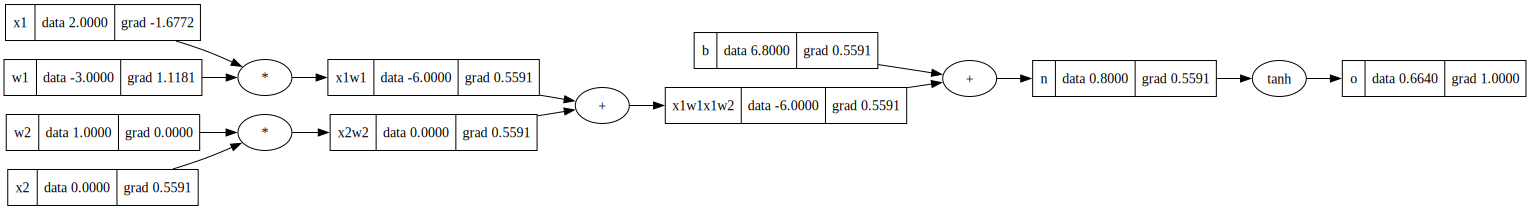

In [8]:
x1= Value(2.0, label='x1')
x2= Value(0.0, label='x2')
w1= Value(-3.0, label='w1')
w2= Value(1.0, label='w2')
b = Value(6.8, label='b')
x1w1=x1*w1
x1w1.label='x1w1'
x2w2=x2*w2
x2w2.label='x2w2'
x1w1x2w2= x2w2+x1w1
x1w1x2w2.label='x1w1x1w2'
n=x1w1x2w2+b
n.label='n'
o=n.tanh()
o.label='o'
o.backward()
draw_dot(o)



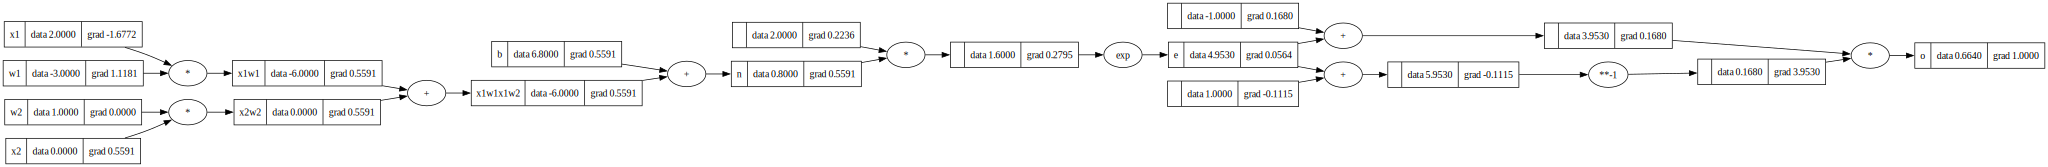

In [9]:
x1= Value(2.0, label='x1')
x2= Value(0.0, label='x2')
w1= Value(-3.0, label='w1')
w2= Value(1.0, label='w2')
b = Value(6.8, label='b')
x1w1=x1*w1
x1w1.label='x1w1'
x2w2=x2*w2
x2w2.label='x2w2'
x1w1x2w2= x2w2+x1w1
x1w1x2w2.label='x1w1x1w2'
n=x1w1x2w2+b
n.label='n'

e_1 = (2*n).exp()

e_1.label='e'
o = (e_1-1)/(e_1+1)

o.label='o'
o.backward()
draw_dot(o)

## Pytorch 

You actually do not need to make this class by yourself. There is a pyTorch framework which can help. HEre is an example: 

In [10]:
import torch


In [11]:

x1 = torch.Tensor([2.0]).double() ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double() ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double() ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double() ; w2.requires_grad = True
b=torch.Tensor([6.8]).double() ; w2.requires_grad = True
n=x1*w1+x2*w2+b
o=torch.tanh(n)
print(o.data.item())
o.backward()

0.6640368768991465


In [12]:
print('----')
print(f"x1 {x1.grad.item()}")      
print(f"x2 {x2.grad.item()}")      
print(f"w1 {x1.grad.item()}")      
print(f"w2 {w2.grad.item()}")      

----
x1 -1.6771650783540835
x2 0.5590550261180278
w1 -1.6771650783540835
w2 0.0


## Neural network itself

Neuron and Layer classes.

1) Neuron is something which has a number of input weights, biases and activation functions.
Each input weights and biases are instances of Value classes. This means that their gradients can be calculated.
When you are calling a neuron it gives you the output on the base of input data, and its weights & biases. 

2) Layer is a list of Neurons, which has a function to calculate output for all Neurons. 

3) MLP is a list of Layers. Each Layer generates output and sends it as input to the next Layer. 

In [13]:
from typing import Any


class Neuron: 
    def __init__(self , nin) -> None:
        self.w =  [(Value(random.uniform(-1,1))) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))


    def __call__(self, x):
        act= sum( (xi*wi for wi, xi in zip(self.w, x)),  self.b ) 
        out= act.tanh()
        return out

    def parameters(self): 
        return self.w +[self.b]

class Layer: 
    def __init__(self,nin,nout) -> None:
        self.neurons= [Neuron(nin) for _ in range(nout)]  

    def __call__(self, x): 
        outs= [n(x) for n in self.neurons]
        return outs[0] if len(outs)==1 else outs
    
    def parameters(self): 
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP : 
    def __init__(self,nin,nouts) -> None:
        sz = [nin]+ nouts
        print(f"sz {sz}")
        self.layers= [Layer(sz[i],sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x): 
        for layer in self.layers: 
            x=layer(x)
        return x
    def parameters(self): 
        return [p for layer in self.layers for p in layer.parameters()]

## Define MLP 
3 input values, and 3 layers with 4,2,1, nodes each.

In [14]:
mlp= MLP(3,[4,2,1])

sz [3, 4, 2, 1]


## Data for training MLP for calssification task

In [15]:
xs = [
    [2.0,3.0,-1.0],
    [3.0, -1.0, 0.5],
    [0.5,1.0,1.0],
    [1.0,1.0,-1.0]
]
ys = [1.0,-1.0, -1.0, 1.0 ]


## Results of forward pass. 
We can see that results of of forward pass are far away form the trye ys. 

In [16]:
ypred = [mlp(x) for x in xs]
ypred

[value(data=0.7066989628950969),
 value(data=0.3005115914234222),
 value(data=0.32655322589713004),
 value(data=0.5375693852562872)]

## Calculate loss 
We use sum of squares of the difference between true and predicted value as a los function.

In [17]:
loss = sum((yout - ygt)**2 for ygt,yout in zip(ys,ypred))

In [18]:
loss

value(data=3.750941432383824)

## Back propagation 
The result of loss function as an instance of a Value class. This means that we can calculate gradients in all weihts and biases by backpropagation. 

In [19]:
loss.backward()

Having all gradients we now can adjust values of all weights and biases (aka parameters) by the gradient value multipllied by lerning rate . 


In [20]:
lerning_rate=-0.1
for i in range(20):
    for p in mlp.parameters(): 
        p.data += lerning_rate * p.grad  
    ypred = [mlp(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt,yout in zip(ys,ypred))
    print(loss)

    for p in mlp.parameters(): 
        p.grad =0 
    loss.backward()

value(data=2.4632435594127484)
value(data=1.6738089690516056)
value(data=0.26321660852197576)
value(data=0.056059202492397146)
value(data=0.04808617734210294)
value(data=0.042087757596856526)
value(data=0.037403536083647305)
value(data=0.033642503265169876)
value(data=0.030556236153871083)
value(data=0.02797858986021962)
value(data=0.025793969772636604)
value(data=0.023919365156241233)
value(data=0.02229358702000103)
value(data=0.02087052711002578)
value(data=0.019614778384490293)
value(data=0.018498701125595582)
value(data=0.017500405326531472)
value(data=0.01660233130235962)
value(data=0.015790231029168805)
value(data=0.01505242402846233)


We can see how loss value is decreasing. 

In [31]:
print (f" true = {ys}, \n predicted =  {[round(pred.data,2)  for pred in ypred]}")


 true = [1.0, -1.0, -1.0, 1.0], 
 predicted =  [0.97, -0.94, -0.92, 0.94]


# Here we see that predicted values are much closer to the true values.